# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 


![Sample Dog Output](images/sample_dog_output.png)


In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
## Import libraries
import numpy as np
             
import matplotlib.pyplot as plt                        
%matplotlib inline    

from PIL import Image
from PIL import Image, ImageFile

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import sys
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

from glob import glob
import cv2  

import random

In [2]:
## Prepare of the enviroment
!mkdir haarcascades
!mkdir images
!mkdir my_tests

In [3]:
## Prepare of the enviroment
## Before upload to enviroment by colab

!mv sample_dog_output.png /content/images
!mv haarcascade_frontalface_alt.xml /content/haarcascades
!mv American_water_spaniel_00648.jpg /content/images
!mv Brittany_02625.jpg /content/images
!mv Curly-coated_retriever_03896.jpg /content/images
!mv Labrador_retriever_06449.jpg /content/images
!mv Labrador_retriever_06455.jpg /content/images
!mv Labrador_retriever_06457.jpg /content/images
!mv Welsh_springer_spaniel_08203.jpg /content/images
!mv sample_cnn.png /content/images
!mv sample_human_output.png /content/images
!mv he.jpg /content/my_tests
!mv me.jpg /content/my_tests
!mv Helena.jpg /content/my_tests
!mv persa_cat.jpg /content/my_tests
!mv rabbit.jpg /content/my_tests
!mv siames_cat.jpg /content/my_tests
!mv passaro.jpg /content/my_tests
!mv pug_dog.jpg /content/my_tests
!mv shih_tzu.jpg /content/my_tests
!mv dono.jpg /content/my_tests

In [4]:
## Download the dog dataset
!wget -q https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip
!rm dogImages.zip

In [5]:
## Download the human dataset
!wget -q http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf lfw.tgz
!rm lfw.tgz

In [6]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


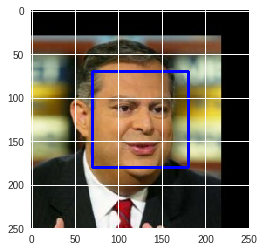

In [7]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

__What percentage of the first 100 images in human_files have a detected human face?__

  There are 96.0 % human images in human_files_short.

__What percentage of the first 100 images in dog_files have a detected human face?__

  There are 7.0 % dog images in dog_files_short.

In [9]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

## What percentage of the first 100 images in human_files have a detected human face?
sum_humans = 0
perc_humans = 0
for i in human_files_short:
    if face_detector(i) == True:
        sum_humans += 1
perc_humans = sum_humans/1 
print("There are {} % human images in human_files_short".format(perc_humans))

## What percentage of the first 100 images in dog_files have a detected human face?
sum_dogs = 0
perc_dogs = 0
for i in dog_files_short:
    if face_detector(i) == True:
        sum_dogs += 1
perc_dogs = sum_dogs/1   
print("There are {} % dog images in dog_files_short".format(perc_dogs))

There are 96.0 % human images in human_files_short
There are 7.0 % dog images in dog_files_short


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:17, 31192213.48it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [12]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    mean  =  np.array([0.229, 0.224, 0.225])
    std = np.array([0.485, 0.456, 0.406]) 
    
    image = Image.open(img_path)
    image = TF.resize(image, 256)
    image = TF.center_crop(image,224)
    image = TF.to_tensor(image)
    image = TF.normalize(image,mean,std)
    
    image = image.cuda()
    
    with torch.no_grad():
        #
        VGG16.eval()

        predictions = VGG16.forward(image.view(1,3,224,224))

        predictions = torch.exp(predictions)
        probs, idx_class = predictions.topk(1, dim=1)
        idx_class = int(idx_class)
      
    # predicted class index
    return idx_class 

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    dog_dect = VGG16_predict(img_path)
    
    # true/false
    return  dog_dect >= 151 and dog_dect <=268 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

__What percentage of the images in human_files_short have a detected dog?__

There are 0 % dog images in human_files_short


__What percentage of the images in dog_files_short have a detected dog?__

There are 98.0 % dog images in dog_files_short

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## What percentage of the images in human_files_short have a detected dog?
sum_dogs_hum_f = 0
perc_dogs_hum_f = 0
for i in human_files_short:
    if dog_detector(i) == True:
        sum_dogs_hum_f  += 1
perc_humans = sum_dogs_hum_f /1 
print("There are {} % dog images in human_files_short".format(perc_dogs_hum_f))

## What percentage of the images in dog_files_short have a detected dog?
sum_dogs = 0
perc_dogs = 0
for i in dog_files_short:
    if dog_detector(i) == True:
        sum_dogs += 1
perc_dogs = sum_dogs/1   
print("There are {} % dog images in dog_files_short".format(perc_dogs))

There are 0 % dog images in human_files_short
There are 98.0 % dog images in dog_files_short


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [15]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [16]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 64

# specify transforms
mean =  np.array([0.229, 0.224, 0.225])
std = np.array([0.485, 0.456, 0.406])

train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomRotation(degrees=0.15), 
                                       transforms.RandomHorizontalFlip(p=0.2),
                                       transforms.RandomVerticalFlip(p=0.4),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])


# Load the datasets with ImageFolder
data_dir =  'dogImages'
dataloaders = {}
train_set = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_set = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)
test_set  = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, 
                                           num_workers=num_workers, 
                                           shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           num_workers=num_workers, 
                                           shuffle=False)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

**How does your code resize the images (by cropping, stretching, etc)?** 

The image had been resized by the transform "RandomResizedCrop(224)"

 **What size did you pick for the input tensor, and why?** 
 
The input tensor size is [64, 3, 224, 224]. 
If the image is too large, it will result in high training time and increased memory consumption (normally GPU).

There are 3 things which must be assessed to a good performance:

- image size
- batch size
- model complexity

**Did you decide to augment the dataset? If so, how (through translations, flips, rotations, etc)? If not, why not?**

Yes, I did. I decided to augment the dataset because this project has limited data, 8351 dog images.
Small datasets is a of the issues with transfer learning and we can soften this issue with augmentation.
I used some transformations:
- transforms.RandomRotation(degrees=0.15)
- transforms.RandomHorizontalFlip(p=0.2)
- transforms.RandomVerticalFlip(p=0.4)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [17]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # 1 convolutional layer (sees 3x224x224 image tensor)
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2, bias=True)
        # batch normalization 
        self.b1 = nn.BatchNorm2d(32)
              
        # 2 convolutional layer (sees 32x112x112 tensor)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2, bias=True)
        # batch normalization 
        self.b2 = nn.BatchNorm2d(64)  
        
        # 3 convolutional layer (sees 32x56x56 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, bias=True)
        # batch normalization 
        self.b3 = nn.BatchNorm2d(128)     
        
        # 4 convolutional layer (sees 64x28x28 tensor)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1, bias=True) 
        # batch normalization 
        self.b4 = nn.BatchNorm2d(256)   
        
        # 5 convolutional layer (sees 128x14x14 tensor)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1, bias=True) 
        # batch normalization 
        self.b5 = nn.BatchNorm2d(512)           
        
        # 6 convolutional layer (sees 512x7x7 tensor)
        self.conv6 = nn.Conv2d(512, 1024, 3, padding=1, bias=True)
        # batch normalization 
        self.b6 = nn.BatchNorm2d(1024)           
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (1024 * 7 * 7 -> 512)
        self.fc1 = nn.Linear(1024 * 7 * 7, 512, bias=True)
                
        # linear layer (512 -> 133)
        self.fc2 = nn.Linear(512, 133, bias=True)
        
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        
        # seq01
        x = self.pool(self.b1(F.relu(self.conv1(x))))
                
        # seq02
        x = self.pool(self.b2(F.relu(self.conv2(x))))      

        # seq03
        x = self.pool(self.b3(F.relu(self.conv3(x))))
        
        # seq04
        x = self.pool(self.b4(F.relu(self.conv4(x))))
        
        # seq05
        x = self.pool(self.b5(F.relu(self.conv5(x))))
        
        # seq06
        x = self.b6(F.relu(self.conv6(x)))     

        # flatten image input
        x = x.view(-1,1024 * 7 * 7)
        
        # add 1st hidden layer, without relu activation function
        x = F.relu(self.fc1(x)) 
        
        # add dropout layer 
        x = self.dropout(x)
        
        # add 2nd hidden layer, without relu activation function
        x = self.fc2(x)
   
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

**1.** First I created a starting point with a very simple architecture. The first architecture had 5 convolutional networks (Conv2d), "MaxPool2d(2, 2)", 2 fully connected layers (Linear) and without dropout. The first convolutional layer started with 16 filters and the last had 256 filters. After 60 epochs and 8 hours of runtime I reached an accuracy of around 17% (test dataset).

The My goal was improvement this result.

**2.** After I added more one convolutional layer (total 6 Conv2d) and I executed 60 epochs. The result was worse and the runtime above 8 hours. I reached an accuracy of around 15% (test dataset).

**3.** I added batch normalizations after of each convolutional layer (total 6). After 60 epochs the accuracy was around 18% (test dataset).

**4.** I read the papers of "resnet" and "densenet" then I decided to add more 4 convolutional layers (total = 10) and organized them within "stacks". I removed the last fully connected  layer (now only one) and created "shortcuts" to decrease the runtime. After 60 epochs I reached an accuracy of around 23% (test dataset).

**5.** My architecture had some troubles:

- My model was in overfitting
- The training loss was decreasing but the validation loss didn't decrease of 3.3 after the epoch 30
- The runtime to 60 epochs was above 8 hours
- The change of "training loss" between epochs wasn't good, less of 0.001
- The strides were lower values (1 or 2)
- I wasn't saving the better model each epoch when the validation loss decreased

**6.** I did some adjustments to my model:

- I Removed the "stacks" and "shortcuts"
- I reduced the size of your network to 6 convolutional layers (Conv2d)
- I added more one fully connected (now 2 fully connected layers)
- Added dropout (= 0.20) after first fully connected layer
- I have adjusted the "strides" to greater values (from 1 or 2 to 3 or 5)
- I modified the size of the filters. Now it starts and ends with larger sizes
- I added weight_decay = 0.001 within of the optimizer
- I started saving the model with every decrease in the validation

**7.** Final  architecture:

**Input tensor:**
- color images of size 224x224x3

**Conv-1:**
- The first convolutional layer consists of 32 kernels of size 112×112 applied with a stride of 5 and padding of 2.
- Batch normalization-1: nn.BatchNorm2d(32)
- MaxPool-1: The maxpool layer (nn.MaxPool2d(2, 2)) following Conv-1 consists of pooling size of 2×2. 

**Conv-2:**
- The second convolutional layer consists of 64 kernels of size 56x56 applied with a stride of 5 and padding of 2.
- Batch normalization-2: nn.BatchNorm2d(64)
- MaxPool-2: The maxpool layer following Conv-2 consists of pooling size of 2×2. 

**Conv-3:**
- The third convolutional layer consists of 128 kernels of size 28x28 applied with a stride of 3 and padding of 1.
- Batch normalization-3: nn.BatchNorm2d(128)
- MaxPool-3: The maxpool layer following Conv-3 consists of pooling size of 2×2.

**Conv-4:**
- The  fourth convolutional layer consists of 256 kernels of size 14x14 applied with a stride of 3 and padding of 1.
- Batch normalization-4: nn.BatchNorm2d(256)
- MaxPool-4: The maxpool layer following Conv-4 consists of pooling size of 2×2.

**Conv-5:**
- The  fifth convolutional layer consists of 512 kernels of size 7x7 applied with a stride of 3 and padding of 1.
- Batch normalization-5: nn.BatchNorm2d(512)
- MaxPool-5: The maxpool layer following Conv-5 consists of pooling size of 2×2.

**Conv-6**
- The  sixth convolutional layer consists of 1024 kernels of size 7x7 applied with a stride of 3 and padding of 1.
- Batch normalization-6: nn.BatchNorm2d(1024)

**Flatten image input:**
- x.view(-1,1024 * 7 * 7)

**FC-1:**
- The first fully connected layer. Linear(1024 x 7 x 7, 512, bias=False)

**Dropout layer:**
- nn.Dropout(0.2)

**FC-2:**
- The second fully connected layer. Linear(512, 133, bias=False)

**8.**  After the adjustments, I ran  140 epochs of the final architecture.
- The architecture accuracy of around 56.00 %

**Others tests:**

- In my first architecture I tested any optimizers (SGD, ADAM and Adagrad) and chose to follow with adagrad (learning rate = 0.01and weight_learning = 0.001) because it had a better performance.

- I created a function that initialized the weights, but the result was very bad, so I removed this function and do not use it in my final architecture.

- I tested several filter sizes and chose to follow with the final architecture presented.

- I tested 2 schedulers (ReduceLROnPlateau and CosineAnnealingLR) in my project, but I decided to follow without scheduler because the performance wasn't better

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [18]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adagrad(model_scratch.parameters(), lr=0.01, weight_decay=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    # move tensors to GPU if CUDA is available
    if use_cuda:
        model.cuda()

    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        # print training/validation statistics 
        print('Epoch: {}\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss  

    # return trained model
    return model      

In [20]:
# train the model
loaders_scratch = {'train':train_loader, 'valid': valid_loader, 'test': test_loader}

In [21]:
##################### MOUNT YOU GOOGLE DRIVE AS A FOLDER ######################
from google.colab import drive
gdrive_dir = '/gdrive'
drive.mount(gdrive_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [22]:
gdrive_dir = gdrive_dir+'/My Drive/Colab Notebooks/'
save_path = gdrive_dir+'model_scratch.pt'

In [23]:
n_epochs = 140

model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, save_path)

Epoch: 1	Training Loss: 7.120643 	Validation Loss: 4.917231
Validation loss decreased (inf --> 4.917231).  Saving model ...
Epoch: 2	Training Loss: 4.897214 	Validation Loss: 4.889499
Validation loss decreased (4.917231 --> 4.889499).  Saving model ...
Epoch: 3	Training Loss: 4.890442 	Validation Loss: 4.904916
Epoch: 4	Training Loss: 4.887759 	Validation Loss: 4.878487
Validation loss decreased (4.889499 --> 4.878487).  Saving model ...
Epoch: 5	Training Loss: 4.886217 	Validation Loss: 4.883743
Epoch: 6	Training Loss: 4.881458 	Validation Loss: 4.865956
Validation loss decreased (4.878487 --> 4.865956).  Saving model ...
Epoch: 7	Training Loss: 4.883282 	Validation Loss: 4.866477
Epoch: 8	Training Loss: 4.864966 	Validation Loss: 4.822003
Validation loss decreased (4.865956 --> 4.822003).  Saving model ...
Epoch: 9	Training Loss: 4.848325 	Validation Loss: 4.809522
Validation loss decreased (4.822003 --> 4.809522).  Saving model ...
Epoch: 10	Training Loss: 4.826747 	Validation Loss:

In [24]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(save_path))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [25]:
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [26]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.916917


Test Accuracy: 56% (470/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [27]:
## TODO: Specify data loaders
# I going to use the same data loaders from the previous step
loaders_transfer  = loaders_scratch 

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [28]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# define densenet121 model
model_transfer = models.densenet121(pretrained=True)

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 133)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Freeze parameters
for param in model_transfer.parameters(): 
    param.requires_grad = False

# Update classifier
model_transfer.classifier = classifier

# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
32342954it [00:00, 58445813.46it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



a. First I chose the model densenet121.  How I reached a good performance with this model after many tests in my challenge project (Pytorch Scholarship Challenge - Phase 01), I resolved used it again.

b. Transfer learning involves taking a pre-trained neural network and adapting the neural network to a new, different data set. 

Depending on both:

-The size of the new data set, and

-The similarity of the new data set to the original data set

In this case, the new data set is small, and new data is similar to original training data. Then following the recommendations:

- I sliced off the end of the neural network (last fully connected);
- I added a new fully connected layer that matches the number of classes in the new data set (133);
- I randomized the weights of the new fully connected layer;
- I froze all the weights from the pre-trained network
- I trained the network to update the weights of the new fully connected layer

To avoid overfitting on the small data set, the weights of the original network were held constant rather than re-training the weights.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [29]:
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.Adagrad(model_transfer.classifier.parameters(),lr=0.01, weight_decay=0.001)

if use_cuda:
    model_transfer.cuda()

In [30]:
##################### MOUNT YOU GOOGLE DRIVE AS A FOLDER ######################
from google.colab import drive
gdrive_dir = '/gdrive'
drive.mount(gdrive_dir)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [31]:
gdrive_dir = gdrive_dir + '/My Drive/Colab Notebooks/'
save_path_transfer = gdrive_dir+'model_transfer.pt'

In [32]:
## TODO: save the model if validation loss has decreased
torch.save(model_transfer.state_dict(), save_path_transfer)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [33]:
loaders_transfer = {'train':train_loader, 'valid': valid_loader, 'test': test_loader}

In [34]:
# train the model
n_epochs = 20
model_transfer = train(n_epochs, loaders_transfer, model_transfer, 
                         optimizer_transfer, criterion_transfer, use_cuda, save_path_transfer)

Epoch: 1	Training Loss: 3.957326 	Validation Loss: 2.240743
Validation loss decreased (inf --> 2.240743).  Saving model ...
Epoch: 2	Training Loss: 2.309641 	Validation Loss: 1.283702
Validation loss decreased (2.240743 --> 1.283702).  Saving model ...
Epoch: 3	Training Loss: 1.858406 	Validation Loss: 1.026255
Validation loss decreased (1.283702 --> 1.026255).  Saving model ...
Epoch: 4	Training Loss: 1.684836 	Validation Loss: 0.862271
Validation loss decreased (1.026255 --> 0.862271).  Saving model ...
Epoch: 5	Training Loss: 1.536199 	Validation Loss: 0.768579
Validation loss decreased (0.862271 --> 0.768579).  Saving model ...
Epoch: 6	Training Loss: 1.481610 	Validation Loss: 0.736100
Validation loss decreased (0.768579 --> 0.736100).  Saving model ...
Epoch: 7	Training Loss: 1.428403 	Validation Loss: 0.679974
Validation loss decreased (0.736100 --> 0.679974).  Saving model ...
Epoch: 8	Training Loss: 1.386118 	Validation Loss: 0.642665
Validation loss decreased (0.679974 --> 0.

In [35]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load(save_path_transfer))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.547784


Test Accuracy: 85% (711/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [37]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
class_names_folders = [item[:] for item in loaders_transfer['train'].dataset.classes]

In [38]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_breed_transfer(img_path):
    mean  =  np.array([0.229, 0.224, 0.225])
    std = np.array([0.485, 0.456, 0.406]) 
  
  # load the image and return the predicted breed
    image = Image.open(img_path)
    image = TF.resize(image, 256)
    image = TF.center_crop(image,224)
    image = TF.to_tensor(image)
    image = TF.normalize(image,mean,std)

    image = image.cuda()

    with torch.no_grad():
        model_transfer.eval()

    predictions = model_transfer.forward(image.view(1,3,224,224))

    predictions = torch.exp(predictions)
    probs, idx_class = predictions.topk(1, dim=1)
    idx_class = int(idx_class)
    breed_dog = class_names[idx_class]
    breed_dog_folder = 'dogImages/train/' + class_names_folders[idx_class]

    return breed_dog, breed_dog_folder

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [39]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
## handle cases for a human face, dog, and neither

def run_app(img_path):
    breed_dog, breed_dog_folder = predict_breed_transfer(img_path)

    for path, subdirs, breed_p in os.walk(breed_dog_folder):
        
        path_img2 = str(path + '/' + random.choice(breed_p))
  
        image = Image.open(img_path) # original image
        img2 = Image.open(path_img2) # other image, same breed
        
        if dog_detector(img_path) is True:
            fig, axs = plt.subplots(ncols=2, nrows=1,figsize=(8, 8))
            rect = fig.patch # a rectangle instance
            rect.set_facecolor('whitesmoke')
            fig.suptitle('This is a dog! \n Your breed is: ' + breed_dog, fontsize=20, color='black')

            axs = axs.flatten()

            axs[0].imshow(image)
            axs[0].set_title('Original Picture', fontsize=15, color='red')
            axs[0].set(xticks=[], yticks=[])

            axs[1].imshow(img2)
            axs[1].set_title("Example of the your breed", fontsize=15, color='red')
            axs[1].set(xticks=[], yticks=[])    
            
            plt.tight_layout()          

        elif face_detector(img_path) is True:
            fig, axs = plt.subplots(ncols=2, nrows=1,figsize=(8, 8))
            rect = fig.patch # a rectangle instance
            rect.set_facecolor('whitesmoke')
            fig.suptitle('You are a human! \n' + 'For me, you look like a ' + breed_dog, fontsize=20, color='black')

            axs = axs.flatten()

            axs[0].imshow(image)
            axs[0].set_title('Original Picture', fontsize=15, color='red')
            axs[0].set(xticks=[], yticks=[])

            axs[1].imshow(img2)
            axs[1].set_title("Example of the your breed", fontsize=15, color='red')
            axs[1].set(xticks=[], yticks=[])

        else:
            fig, axs = plt.subplots(ncols=1, nrows=1,figsize=(8, 8))
            rect = fig.patch # a rectangle instance
            rect.set_facecolor('whitesmoke')
            fig.suptitle('Sorry, I have not detected neither dogs or humans in this image.', fontsize=20, color='black')
            
            axs.imshow(image)
            axs.set_title('Original Picture', fontsize=15, color='red')
            axs.set(xticks=[], yticks=[])
        return 

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)




The output was what I expected.

Several points of improvement can be done:

- The algorithm could show the probabilities by breed, currently, it shows the first predict.
- The algorithm could show the class of the image that wasn't a dog (for example: "This is a cat", bird, rabbit and so on).
- I improve my algorithm showing one example of the predicted breed. I'd like to show more examples of the identified breed.
- I'd like also to organize the images in a friendlier way with the use of matplotlib.

I'd like to do more tests, for example:

a. What is the output if the image has dogs and humans (together)? I tested one case and the algorithm identifies only the dog.

b. My algorithm doesn't identify children (human). The algorithm must have a treatment when it doesn't recognize correctly.

In [40]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# load filenames for human and dog images
my_files = np.array(glob("/content/my_tests/*"))

# print number of images in each dataset
print('There are %d total images.' % len(my_files))

There are 10 total images.


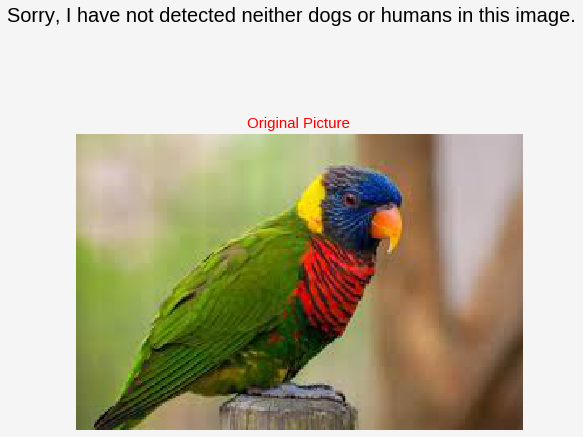

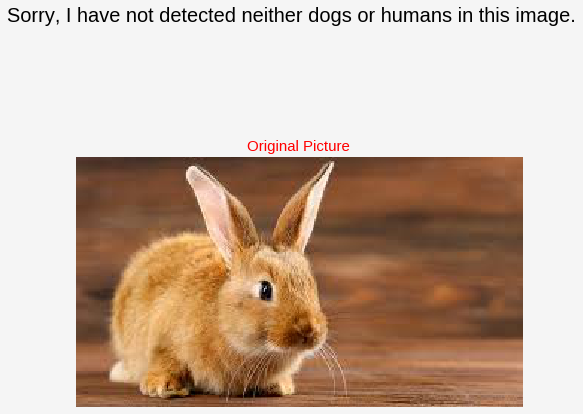

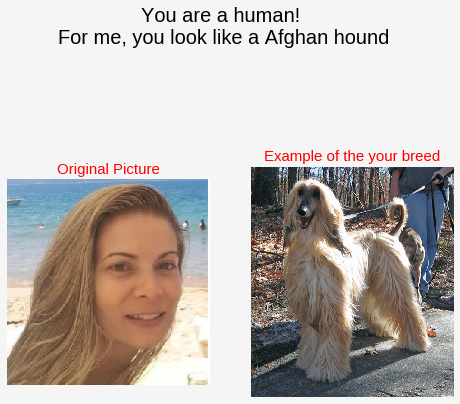

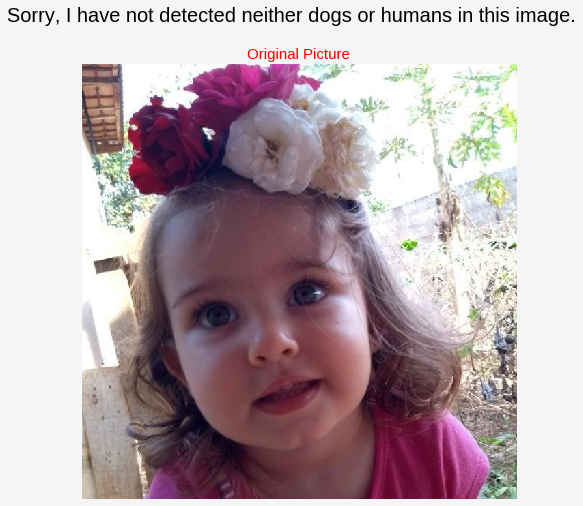

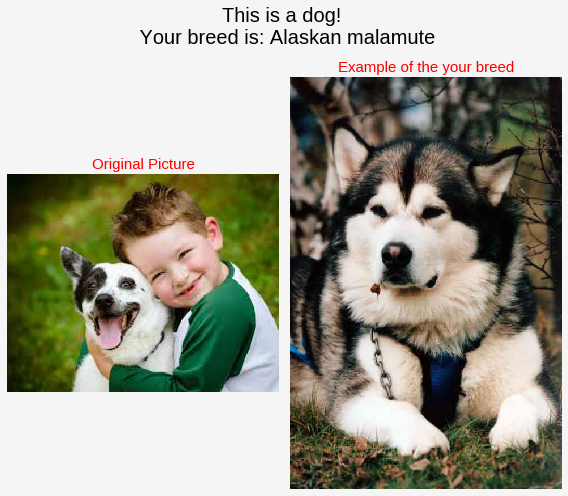

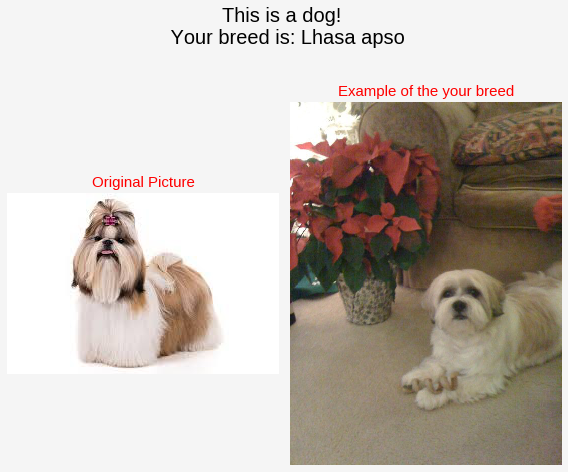

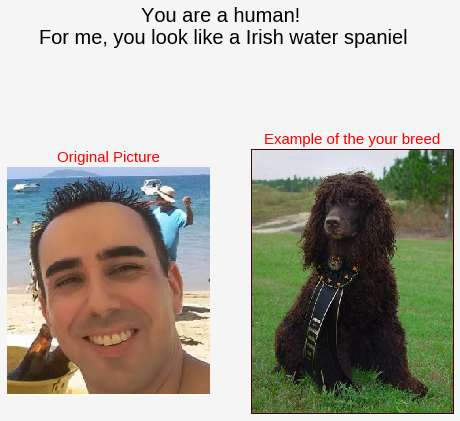

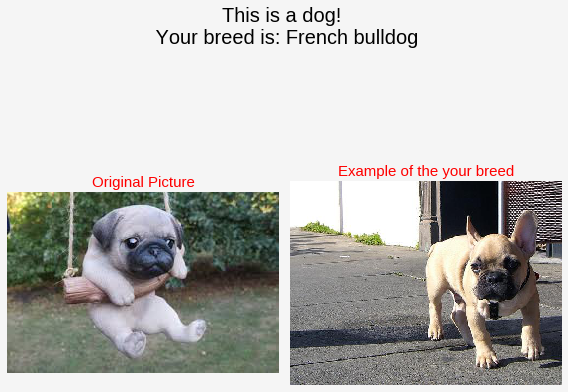

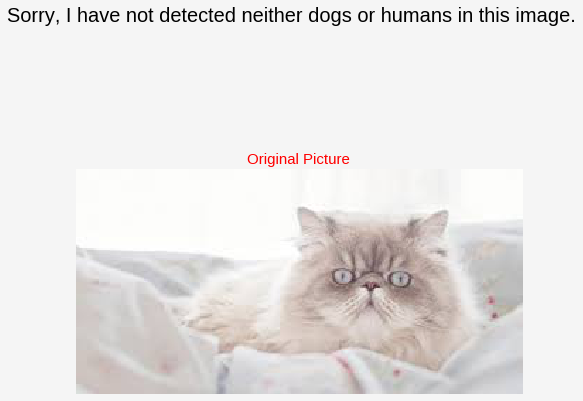

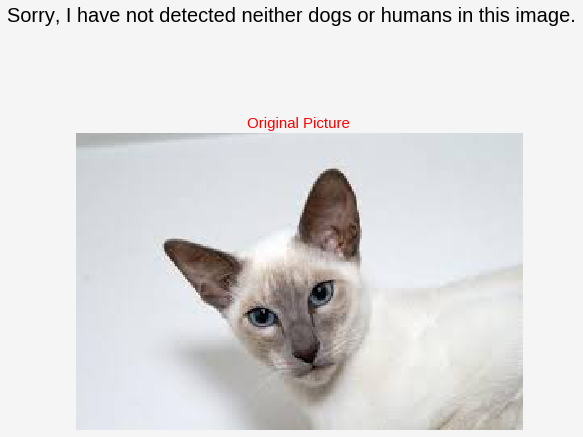

In [41]:
for file in np.hstack((my_files [:])):
    run_app(file)

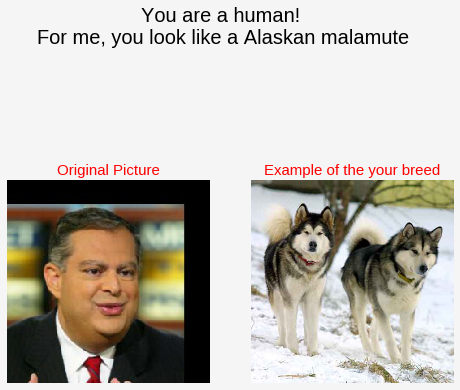

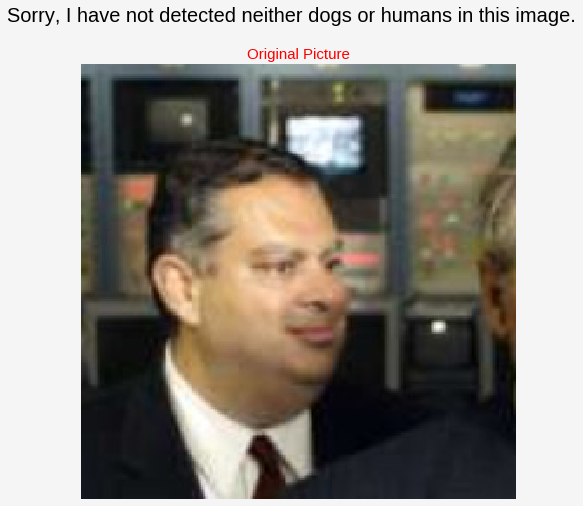

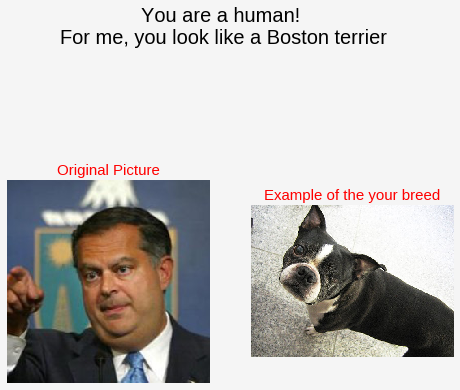

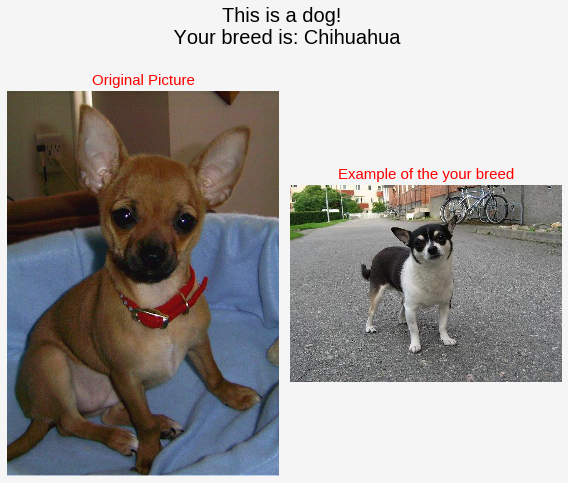

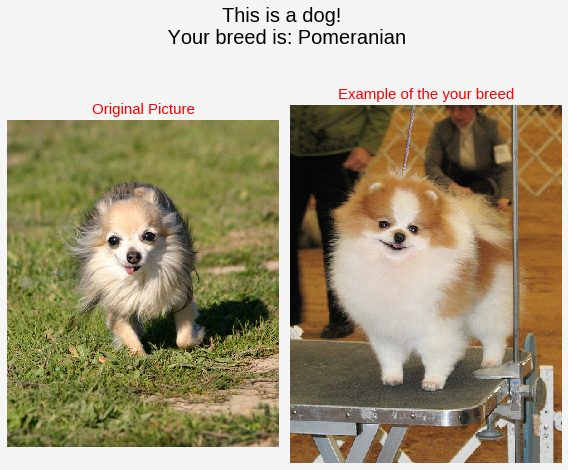

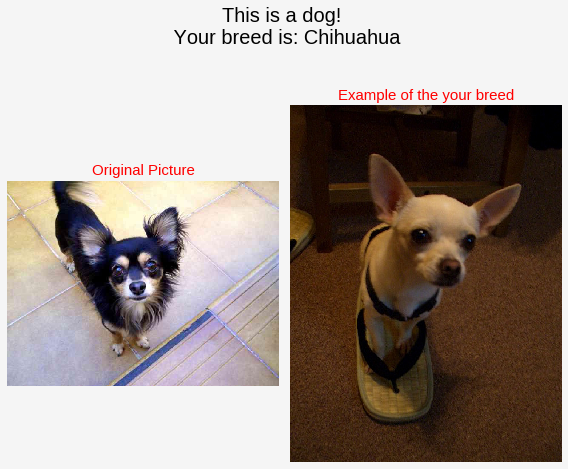

In [42]:
## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)